## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso

import warnings
warnings.filterwarnings('ignore')

## Loading and checking the data set

In [2]:
df = pd.read_csv("Bengaluru_House_Data.csv")
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


## EDA (Exploratory Data Analysis)

### Data exploration 

In [3]:
# checking the number of rows and Columns in the data frame
df.shape

(13320, 9)

In [4]:
#checking the name each columns
df.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [5]:
# checking the info of the data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


We discovered an unexpected 'total sqft' column with a data type of 'object' in the dataset. We will investigate it further.

1. Missing values

In [6]:
# check for missing values
df.isnull().sum()

area_type 0
availability 0
location 1
size 16
society 5502
total_sqft 0
bath 73
balcony 609
price 0
dtype: int64

In [7]:
print(f'There are {df.isnull().sum().sum()} null values in the dataset.')
print(f'There are {df.duplicated().sum()} duplicate rows in the dataset.')

There are 6201 null values in the dataset.
There are 529 duplicate rows in the dataset.


2. Categorical variable

<Axes: xlabel='area_type', ylabel='count'>

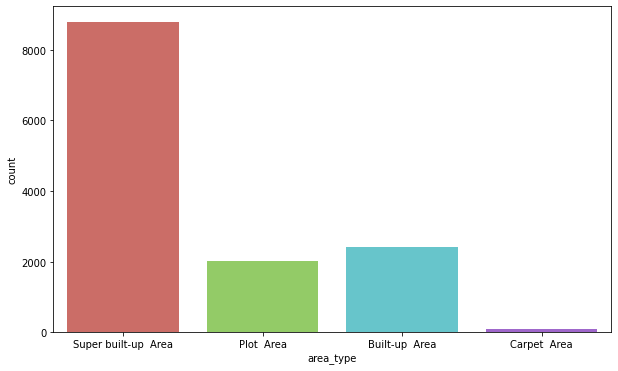

In [8]:
plt.figure(figsize=(10,6))
sns.countplot(x='area_type', data=df, palette="hls", hue='area_type', legend=False)

In [9]:
# Number of different locations
len(df.location.unique())

1306

In [10]:
# Locations with houses for sale that are less than or equal to 10.
location_count = df['location'].value_counts()
location_count_less_10 = location_count[location_count <= 10]
len(location_count_less_10)

1064

We will reduce the number of unique locations. By grouping rare locations into 'other', we can make the model simpler and more stable.

In [11]:
# exploration size column
df["size"].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
 '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
 '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
 '9 BHK', nan, '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
 '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
 '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

From the above, we can see with clarity that 2 different methods represent Bedroom. One is BHK and the other one is Bedroom. So we are making a new column called BHK and we are discarding all the units (like BHK, Bedroom).

3. Numerical variable

In [12]:
df.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


The data is questionable.

Min Bath 1 | Max bath 40

ิMin Balcony 0 | Max Balcony 3

ิMin price 8 | Max price 3600

In [13]:
# exploration total_sqft column
df["total_sqft"].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
 dtype=object)

From the above shows that total_sqft can be a range (e.g., 1133 - 1384). There may be other hidden patterns. We need to explore and fix them next.

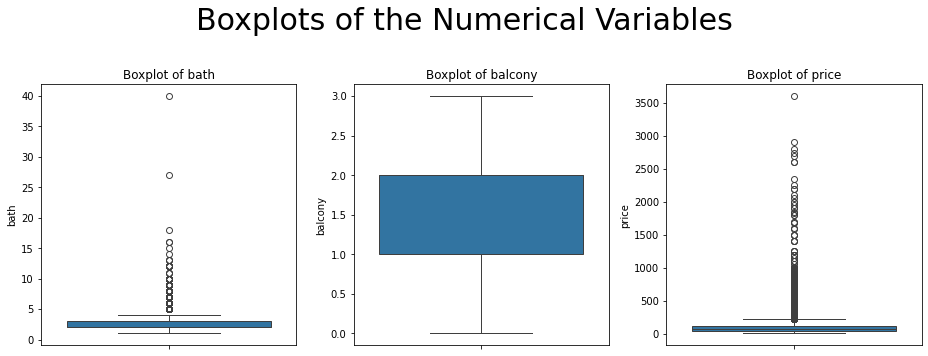

In [14]:
feature = ['bath', 'balcony', 'price']
fig, axes = plt.subplots(1, 3, figsize=(13, 5))

for n, i in enumerate(feature):
    sns.boxplot(data=df, y=i, ax=axes[n])
    axes[n].set_title(f'Boxplot of {i}')

fig.suptitle("Boxplots of the Numerical Variables", fontsize=30)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [15]:
# check outliers
outliers_perc = []

for col_name, col_data in df[feature].items():
    # Column must be of numeric type (not object)
    if df[col_name].dtype != 'O':  # 'O' object data type
        q1 = col_data.quantile(0.25)  # quartile 1 (25%)
        q3 = col_data.quantile(0.75)  # quartile 3 (75%)
        iqr = q3 - q1  # IQR (Interquartile Range)
        
        outliers = col_data[(col_data <= q1 - 1.5 * iqr) | (col_data >= q3 + 1.5 * iqr)]
        
        perc = len(outliers) * 100.0 / len(df)
        outliers_perc.append((col_name, int(perc)))
        print(f"Column {col_name} outliers = {perc:.2f}%")

Column bath outliers = 7.80%
Column balcony outliers = 0.00%
Column price outliers = 9.89%


<Axes: xlabel='bath', ylabel='count'>

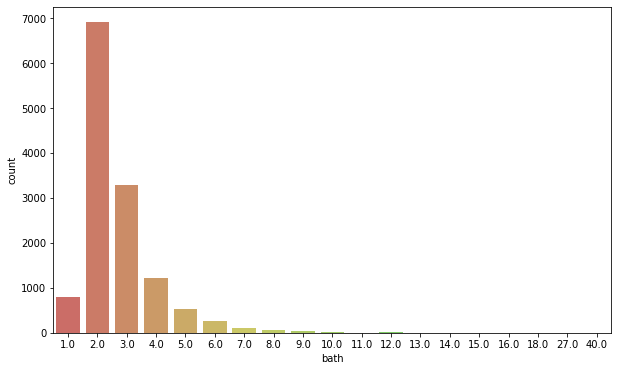

In [16]:
plt.figure(figsize=(10,6))
sns.countplot(x='bath', data=df, palette="hls",hue='bath', legend=False)

<Axes: xlabel='balcony', ylabel='count'>

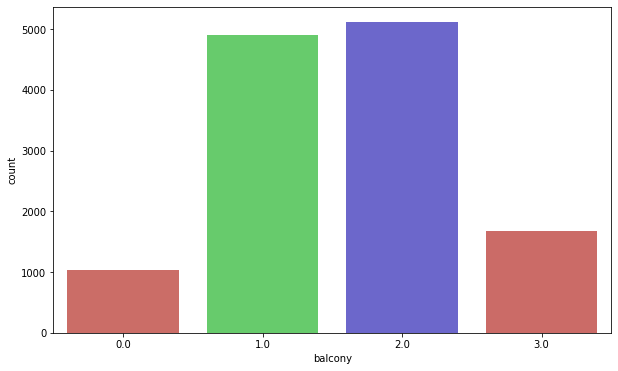

In [17]:
plt.figure(figsize=(10,6))
sns.countplot(x='balcony', data=df, palette="hls", hue='balcony', legend=False)

4. Other Exploration

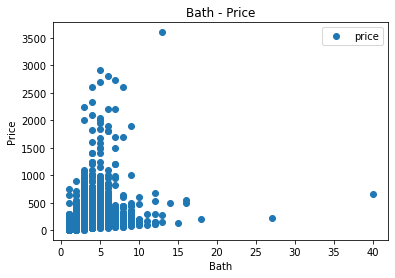

In [18]:
# scatter plot bath vs price
df.plot(x='bath', y='price', style='o')  
plt.title('Bath - Price')  
plt.xlabel('Bath')
plt.ylabel('Price')
plt.show()

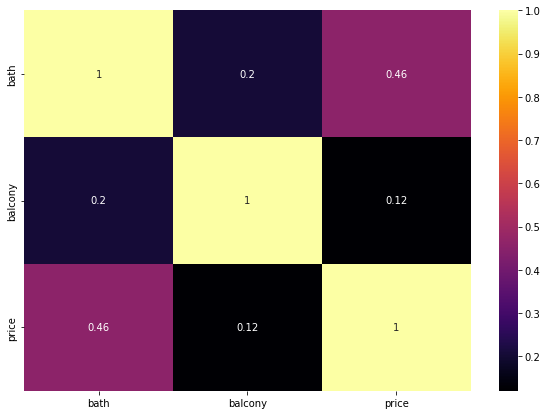

In [19]:
# Heatmap
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), annot=True, cmap='inferno');

## Data Preprocessing

1. Drop unnecessary variables & Missing values

In [20]:
# Dropping less important features
df = df.drop(['area_type', 'availability', 'society', 'balcony'],axis='columns')

# dropping the missing values
df = df.dropna()
# dropping the duplicated values
df = df.drop_duplicates()

In [21]:
print(f'There are {df.isnull().sum().sum()} null values in the dataset.')
print(f'There are {df.duplicated().sum()} duplicate rows in the dataset.')

There are 0 null values in the dataset.
There are 0 duplicate rows in the dataset.


2. Adjust the data type to 'total sqft' to ensure consistency across the dataset.

In [22]:
df["total_sqft"].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
 dtype=object)

In [23]:
# build a function to check float data
def is_float(x):
    try:
        float(x)
    except: 
        return False
    return True

In [24]:
df[~df["total_sqft"].apply(is_float)].head(10)

,location,size,total_sqft,bath,price
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770
648,Arekere,9 Bedroom,4125Perch,9.0,265.000
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000


From the above, total_sqft might be a range like 3090-5002, and we can use the average of the minimum and maximum values. There are also cases like 34.46 Sq. Meter, which can be converted to square feet, but we will drop these specific cases to keep things simple.

In [25]:
# build function to convert rang data to mean data
def convert_sqft_to_num(x):
    token = x.split("-")
    if len(token) == 2:
        return (float(token[0])+float(token[1]))/2
    try:
        return float(x)
    except:
        return None

In [26]:
df["total_sqft"] = df["total_sqft"].apply(convert_sqft_to_num)
# drop none value from convert_sqft_to_num
df = df.dropna()
df.isnull().sum()

location 0
size 0
total_sqft 0
bath 0
price 0
dtype: int64

3. Reduce dimension

In [27]:
len(df.location.unique())

1298

In [28]:
df.location = df.location.apply(lambda x: x.strip())
len(df.location.unique())

1287

In [29]:
location_count = df.groupby("location")["location"].agg("count").sort_values(ascending = False)
location_count

location
Whitefield 500
Sarjapur Road 357
Electronic City 275
Thanisandra 224
Kanakpura Road 215
 ... 
1 Giri Nagar 1
Kanakapura Road, 1
Kanakapura main Road 1
Kannur 1
whitefiled 1
Name: location, Length: 1287, dtype: int64

In [30]:
len(location_count[location_count <= 10])

1057

In [31]:
location_count_less_10 = location_count[location_count <= 10]
location_count_less_10

location
Kalkere 10
Thyagaraja Nagar 10
BTM 1st Stage 10
BEML Layout 10
Vasanthapura 10
 ..
1 Giri Nagar 1
Kanakapura Road, 1
Kanakapura main Road 1
Kannur 1
whitefiled 1
Name: location, Length: 1057, dtype: int64

In [32]:
df.location = df.location.apply(lambda x : "other" if x in location_count_less_10 else x)
len(df.location.unique())

231

## Feature Engineering

1. Create a BHK column extracted from the size column

In [33]:
df["size"].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
 '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
 '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
 '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
 '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
 '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [34]:
# extract number from string
df["bhk"] = df["size"].apply(lambda x: int(x.split(" ")[0]))

In [35]:
df.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


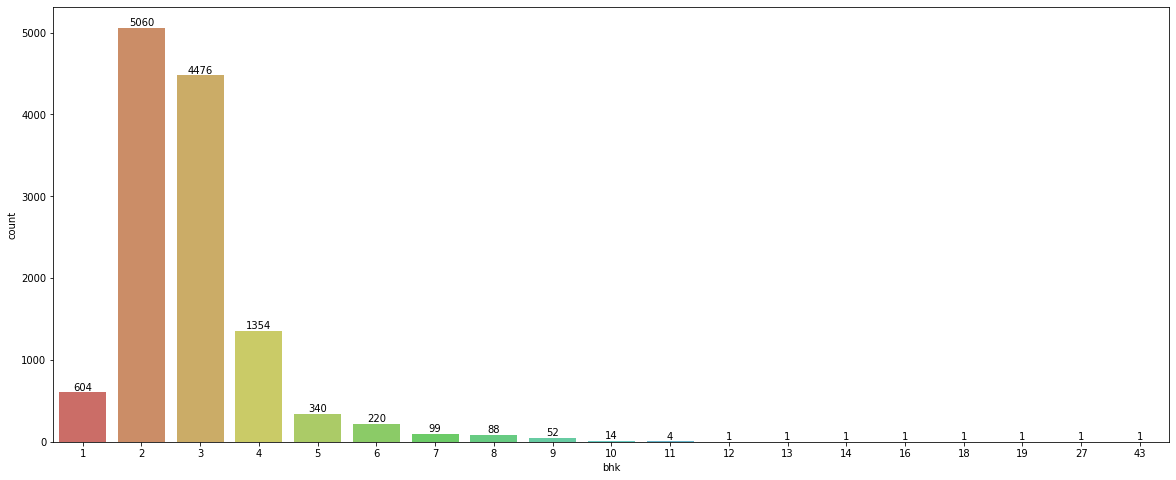

In [36]:
plt.figure(figsize=(20, 8))
ax = sns.countplot(x='bhk', data=df, palette="hls")
# Add annotations on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                color='black')
plt.show()

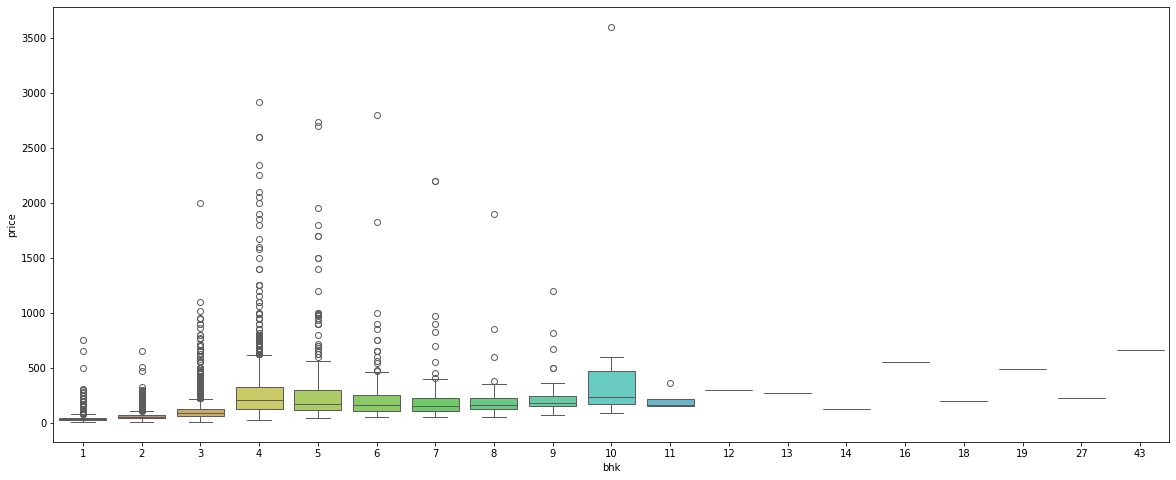

In [37]:
plt.figure(figsize=(20, 8))
sns.boxplot(x = 'bhk', y = 'price', palette="hls", data = df)
plt.show()

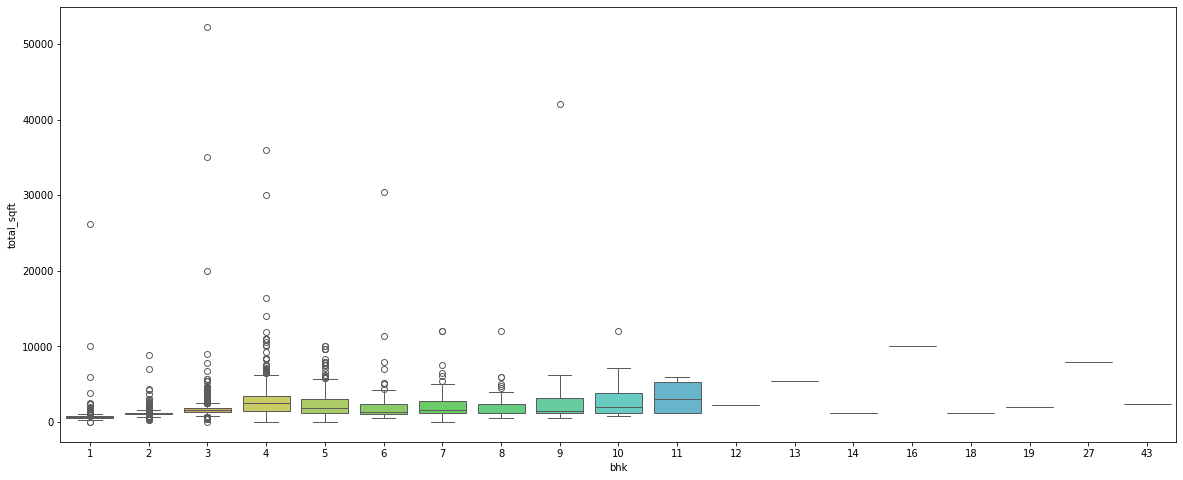

In [38]:
plt.figure(figsize=(20, 8))
sns.boxplot(x = 'bhk', y = 'total_sqft', palette="hls", data = df)
plt.show()

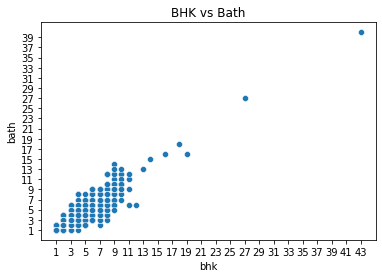

In [39]:
sns.scatterplot(x='bhk', y='bath', data=df)
plt.title("BHK vs Bath")
plt.yticks(ticks=range(int(df['bath'].min()), int(df['bath'].max()) + 1, 2)) 
plt.xticks(ticks=range(df['bhk'].min(), df['bhk'].max() + 1, 2))
plt.show()

2. Adding a new feature (Price per Square Feet)

In [40]:
df["price_per_sqft"] = df["price"]*100000/df["total_sqft"] # lakhs (Indian Rupee - ₹) *100000
df.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [41]:
df.price_per_sqft.describe()

count 1.231900e+04
mean 8.115050e+03
std 1.104734e+05
min 2.678298e+02
25% 4.307692e+03
50% 5.500000e+03
75% 7.452904e+03
max 1.200000e+07
Name: price_per_sqft, dtype: float64

## Data Preprocessing

1. Outlier Removal Based on Space Efficiency

In [42]:
df[(df.total_sqft/df.bhk<300)].head()

df = df[~(df.total_sqft/df.bhk<300)]
df.shape

(11590, 7)

Remove Price Per Square Foot (PPS) Outliers Using IQR

In [43]:
def remove_pps_outlier_iqr(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby("location"):
        # find Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = subdf.price_per_sqft.quantile(0.25)
        Q3 = subdf.price_per_sqft.quantile(0.75)
        # IQR
        IQR = Q3 - Q1
        # whisker
        lower_bound = Q1 - 0.5 * IQR
        upper_bound = Q3 + 0.5 * IQR
        # filter data
        reduced_df = subdf[(subdf.price_per_sqft >= lower_bound) & (subdf.price_per_sqft <= upper_bound)]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

df = remove_pps_outlier_iqr(df)
df.shape

(9479, 7)

3. Filtering Unreasonable Bath-to-BHK Ratios

In [44]:
df[df.bath>df.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1466,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
4839,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6321,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
7807,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


In [45]:
df = df[df.bath<df.bhk+2]
df.shape

(9397, 7)

4. Drop unnecessary feature

In [46]:
df = df.drop(["size","price_per_sqft"],axis="columns")
df.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3


5. One-Hot Encoding for Location

In [47]:
dummies = pd.get_dummies(df.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
df = pd.concat([df,dummies.drop('other',axis='columns')],axis='columns')
df.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
df = df.drop("location" ,axis="columns")
df.head(2)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
df.shape

(9397, 234)

In [51]:
X = df.drop(columns=["price"],axis=1)
X.head()

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
y = df["price"]
y.head()

0 428.0
1 194.0
2 235.0
3 130.0
4 148.0
Name: price, dtype: float64

In [53]:
X_train, X_test, y_trian, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [54]:
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_trian)
lr_clf.score(X_test,y_test)

0.7999043304588038

In [55]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.84042415, 0.82862747, 0.81036611, 0.81155229, 0.82482939])

In [56]:
def find_best_model_using_gridsearchcv(X,y):
    algos = {
        "linear_regression" : {
            "model" : LinearRegression(),
            "params" : {}
        },
        "lasso" : {
            "model" : Lasso(),
            "params" : {
                "alpha" : [1,2],
                "selection" : ["random","cyclic"]
            }
        },
        "decision_tree" : {
            "model" : DecisionTreeRegressor(),
            "params" : {
                "criterion" : ["squared_error","friedman_mse"],
                "splitter" : ["best","random"]
            }
        }
    }

    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config["model"], config["params"], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            "model" : algo_name,
            "best_score" : gs.best_score_,
            "best_params" : gs.best_params_
        })
    return pd.DataFrame(scores,columns=["model","best_score","best_params"])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.823160,{}
1,lasso,0.674740,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.745068,"{'criterion': 'squared_error', 'splitter': 'ra..."


In [57]:
X.columns

Index(['total_sqft', 'bath', 'bhk', '1st Block Jayanagar',
       '1st Phase JP Nagar', '2nd Stage Nagarbhavi', '5th Block Hbr Layout',
       '5th Phase JP Nagar', '6th Phase JP Nagar', '7th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=233)

In [58]:
def predict_price(location,sqft,bath,bhk):
    loc_index = np.where(X.columns==location)[0][0]
    
    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1
    
    return lr_clf.predict([x])[0]

In [59]:
predict_price('Whitefield',1000, 2, 2)

47.60947789483873